# Simple ocean color data classifiers

This notebook applies simple classifications to `ocean color data` in context of the [CBIOMES](https://cbiomes.org) project. It is written in [Julia](https://julialang.org) and can be used interactively via [binder](https://mybinder.org/v2/gh/gaelforget/Cbiomes2019Notebooks/master). 

<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 50px;"/>

### Activate packages for later use

It is assumed that listed packages have aleary been installed using `julia`'s package manager (documentation available [here](https://docs.julialang.org/en/)). 

In [2]:
using Plots, Distributions, NetCDF, NCDatasets

┌ Info: Recompiling stale cache file /Users/gforget/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/gforget/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184


### Observed wavebands

Currently, the `OC-CCI` [satellite data set](https://esa-oceancolour-cci.org) provides remotely sensed reflectance at 6 wavelengths (`wv_cci` in `nm`)

In [3]:
wv_cci=[412, 443, 490, 510, 555, 670]

6-element Array{Int64,1}:
 412
 443
 490
 510
 555
 670

### Optical classification using reflectances

`Fuzzy logic` classifiers defined in [Moore et al 2009](https://doi.org/10.1016/j.rse.2009.07.016) and [Jackson et al 2017](http://dx.doi.org/10.1016/j.rse.2017.03.036) can be used to assign optical class memberships from an `Rrs` vector. While Moore et al define `n=8` classes using an in-situ database, Jackson et al instead define `n=14` classes using a satellite database. The latter benefits from better data coverage across all of the ecological provinces of the global ocean and is used in `OC-CCI`. 

In both cases the classifier is encoded in a mean reflectance spectra (`M[i][1:6]`) and a covariance matrix (`S[i][1:6,1:6]`) provided for each optical class (`i` in `1:n`). Class memberships are then derived by computing the squared Mahalanobis distance to each `M[i]` and passing the result to cumulative chi-squared distribution function (Equations 11 and 12 in [Moore et al 2011](https://doi.org/10.1109/36.942555)).

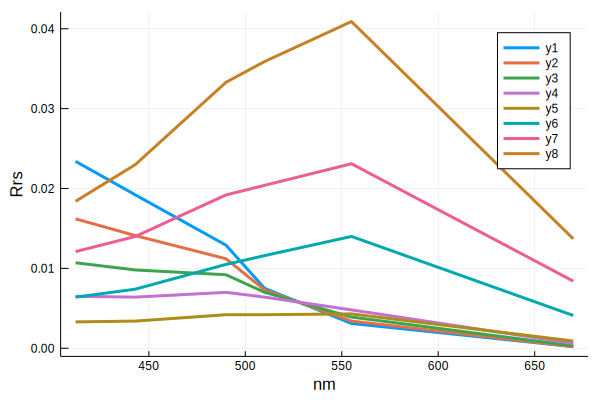

In [4]:
include("../samples/M09.jl")

M09=Dict("M" => M, "S" => S, "Sinv" => inv.(S))
plot(wv_cci,M,w=3); xlabel!("nm"); ylabel!("Rrs")

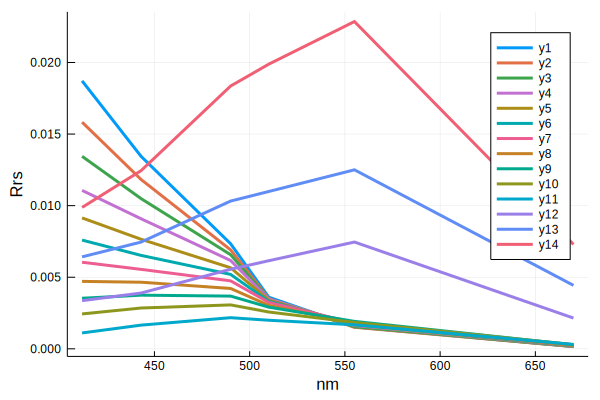

In [5]:
#Jackson et al 2017:
tmpM = ncread("../samples/J17.nc", "cluster_means")
tmpSinv = ncread("../samples/J17.nc", "inverse_covariance")

M=Array{Any,1}(undef,14)
Sinv=Array{Any,1}(undef,14)
for ii=1:length(M)
    M[ii]=vec(tmpM[ii,:])
    Sinv[ii]=tmpSinv[1:6,1:6,ii]
end

J17=Dict("M" => M, "Sinv" => Sinv, "S" => inv.(Sinv))
plot(wv_cci,M,w=3); xlabel!("nm"); ylabel!("Rrs")

### Class membership function

In [6]:
function fcm(M,Sinv,Rrs)
    f=Array{Any,1}(undef,length(M))
    for ii=1:length(M)
        X=vec(Rrs)-M[ii]
        Z=transpose(X)*Sinv[ii]*X
        f[ii]=ccdf(Chisq(6),Z)
    end
    f
end

fcm (generic function with 1 method)

### Apply J17 classifier to 2D region

Read file and display one waveband

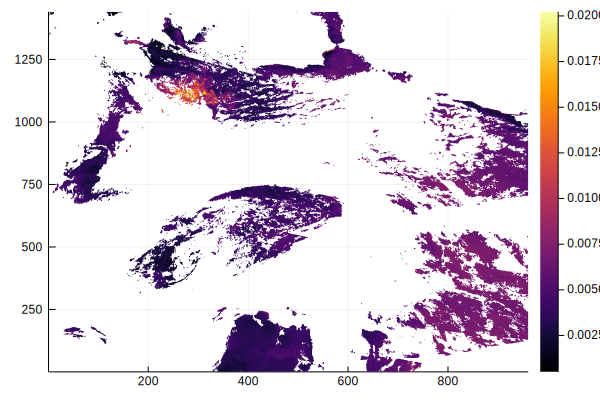

In [7]:
dir0="../samples/"
fil=dir0*"ESACCI-OC-RRS-sample-fv4.0.nc"
ds = Dataset(fil)

Rrs_412=ds["Rrs_412"]
Rrs_443=ds["Rrs_443"]
Rrs_490=ds["Rrs_490"]
Rrs_510=ds["Rrs_510"]
Rrs_555=ds["Rrs_555"]
Rrs_670=ds["Rrs_670"]

heatmap(ds["Rrs_490"][:,:,1])

Find points that have a full set of input

In [8]:
tmp=fill(false,size(Rrs_412))
for ii in eachindex(Rrs_412)
    !ismissing(Rrs_412[ii]) ? tmp[ii]=!ismissing(Rrs_443[ii].*Rrs_490[ii].*Rrs_510[ii].*Rrs_555[ii].*Rrs_670[ii]) : nothing
end
ii=findall(tmp)

291724-element Array{CartesianIndex{3},1}:
 CartesianIndex(1348, 1, 1)  
 CartesianIndex(1349, 1, 1)  
 CartesianIndex(1350, 1, 1)  
 CartesianIndex(1351, 1, 1)  
 CartesianIndex(1352, 1, 1)  
 CartesianIndex(1353, 1, 1)  
 CartesianIndex(1424, 1, 1)  
 CartesianIndex(1425, 1, 1)  
 CartesianIndex(1426, 1, 1)  
 CartesianIndex(1427, 1, 1)  
 CartesianIndex(1349, 2, 1)  
 CartesianIndex(1350, 2, 1)  
 CartesianIndex(1351, 2, 1)  
 ⋮                           
 CartesianIndex(988, 960, 1) 
 CartesianIndex(989, 960, 1) 
 CartesianIndex(990, 960, 1) 
 CartesianIndex(991, 960, 1) 
 CartesianIndex(992, 960, 1) 
 CartesianIndex(993, 960, 1) 
 CartesianIndex(994, 960, 1) 
 CartesianIndex(1028, 960, 1)
 CartesianIndex(1030, 960, 1)
 CartesianIndex(1031, 960, 1)
 CartesianIndex(1032, 960, 1)
 CartesianIndex(1033, 960, 1)

Compute memberships

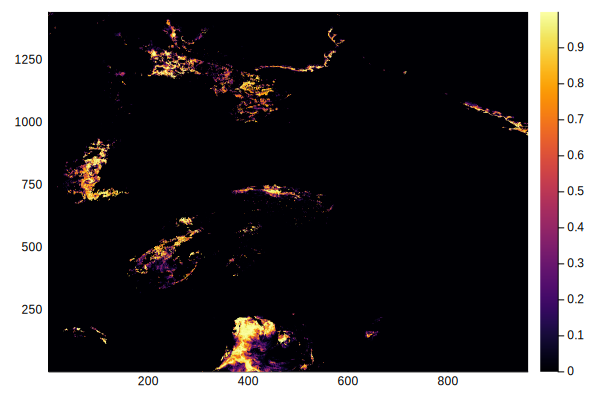

In [9]:
mbrshp=Array{Float64,3}(undef,(1440,960,14))
for jj=1:length(ii); 
    kk=ii[jj]
    Rrs_tmp=[Rrs_412[kk] Rrs_443[kk] Rrs_490[kk] Rrs_510[kk] Rrs_555[kk] Rrs_670[kk]]
    mbrshp[kk[1],kk[2],:]=fcm(J17["M"],J17["Sinv"],Rrs_tmp)
end

heatmap(mbrshp[:,:,10])